<a href="https://colab.research.google.com/github/Apple03244/Colaboratory/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import google.colab as cb
f=cb.files.upload()

Saving MyKaggle.py.zip to MyKaggle.py.zip


In [46]:
!unzip /content/MyKaggle.py.zip
!rm /content/MyKaggle.py.zip

Archive:  /content/MyKaggle.py.zip
  inflating: MyKaggle.py             


In [47]:
from MyKaggle import startkaggle

In [48]:
startkaggle()

Already done


In [49]:
!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 50.0MB/s]


In [50]:
!unzip titanic.zip
!rm titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


----

In [7]:
import pandas as pd
train=pd.read_csv("/content/train.csv")
test=pd.merge(pd.read_csv("/content/test.csv"),pd.read_csv("/content/gender_submission.csv"))

## Preprccessing

In [10]:
import sklearn.preprocessing as skpre
import sklearn.model_selection as skmod
import sklearn.impute as skimp

In [8]:
import matplotlib.pyplot as plt
import seaborn as sb

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [51]:
nouse_cols=["PassingerId","Name","Ticket","Cabin"]
numeric_cols=["Age","SibSp","Parch","Fare"]
ordinal_cols=["Pclass"]
cate_cols=["Sex","Embarked"]
target_col=["Survived"]

In [52]:
train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [53]:
import scipy.stats as sps

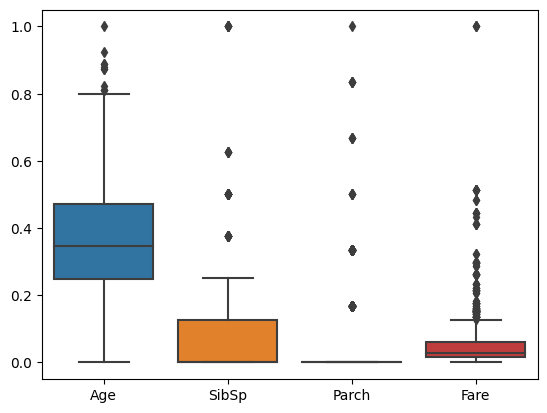

In [54]:
plt.figure()
sb.boxplot(data=pd.DataFrame(skpre.minmax_scale(train[numeric_cols]),columns=numeric_cols))
plt.show()
plt.close()

<Figure size 640x480 with 0 Axes>

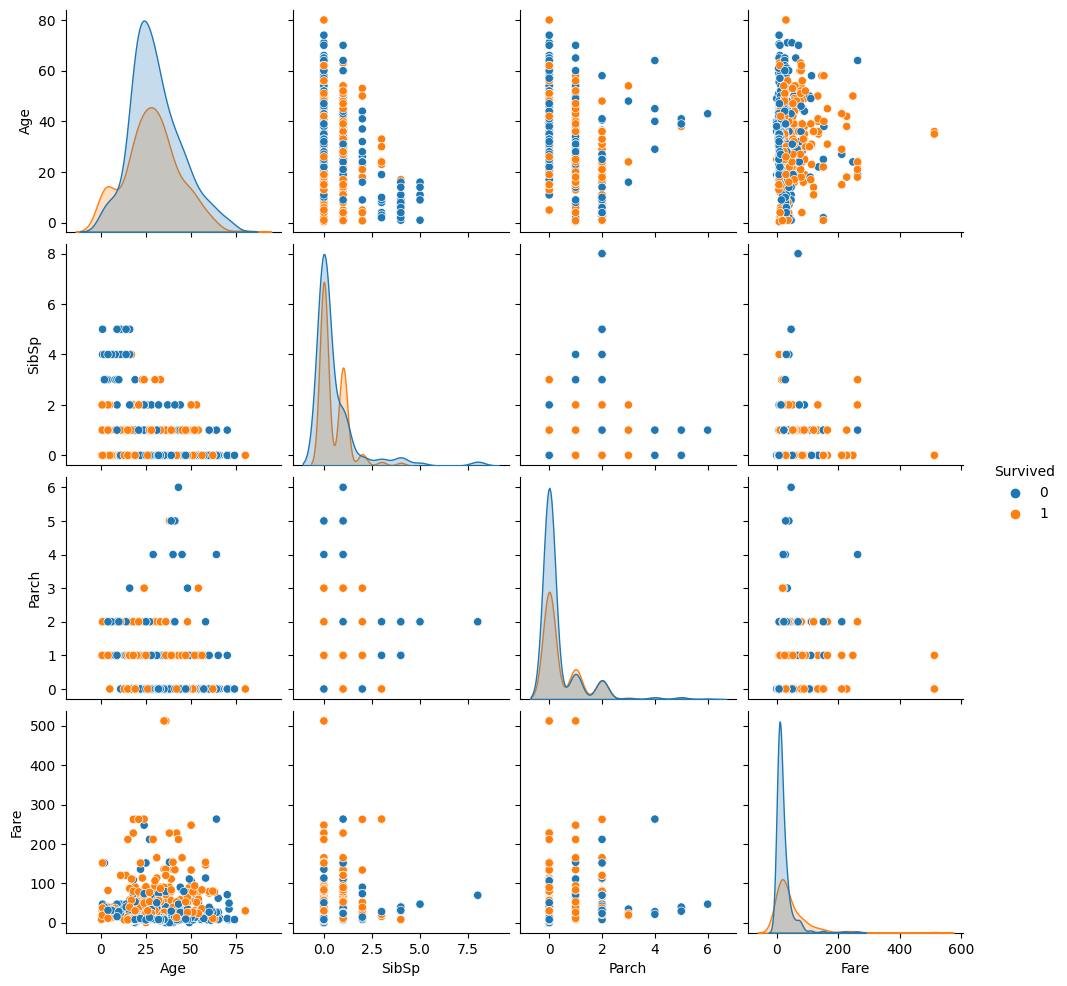

In [56]:
plt.figure()
sb.pairplot(data=train[numeric_cols+target_col],hue=target_col[0])

In [76]:
import sklearn.base as skbase

In [ ]:
skbase.TransformerMixin

### Make prerpocessing pipeline and save it

In [146]:
%%writefile titanic_prerpocess.py
import sklearn.pipeline as skpip
import sklearn.preprocessing as skpre
import sklearn.compose as skcom
import sklearn.impute as skimp
import scipy.stats as sps
import sklearn.base as skbase
import numpy as np
import pandas as pd

class preprocess(skbase.BaseEstimator,skbase.TransformerMixin):
  def __init__(self)->None:
    super().__init__()
    self.nouse_cols=["PassengerId","Name","Ticket","Cabin"]
    self.numeric_cols=["Age","SibSp","Parch","Fare"]
    self.ordinal_cols=["Pclass"]
    self.cate_cols=["Sex","Embarked"]
    self.target_col=["Survived"]
    self.numeric_pip=skpip.make_pipeline(skimp.SimpleImputer(strategy="mean"),skpre.MinMaxScaler())
    self.cate_pip=skpip.make_pipeline(skimp.SimpleImputer(strategy="most_frequent"),skpre.OneHotEncoder(handle_unknown="ignore"))

  class passthrough(skbase.BaseEstimator,skbase.TransformerMixin):
    def __init__(self)->None:
      super().__init__()
    def fit(self,X,y=None):
      self.columns=X.columns
      return self
    def transform(self,X,y=None):
      return X
    def get_feature_names_out(self):
      return self.columns

  def fit(self,X,y=None):
    self.pipeline=skcom.make_column_transformer((self.passthrough(),self.ordinal_cols+self.target_col),
                                           (self.numeric_pip,self.numeric_cols),
                                           (self.cate_pip,self.cate_cols),
                                           remainder="drop")
    self.pipeline.fit(X)
    return self.pipeline

  def transform(self,X,y=None):
    column_name=[]
    for x in self.pipeline.named_transformers_:
      try:
        column_name.extend(self.pipeline.named_transformers_[x].get_feature_names_out())
      except:
        continue
    return pd.DataFrame(data=self.pipeline.transform(X),columns=column_name)

Writing titanic_prerpocess.py


In [147]:
pre_pipe=preprocess()
pre_pipe.fit(train)

ColumnTransformer(transformers=[('passthrough', passthrough(),
                                 ['Pclass', 'Survived']),
                                ('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex', 'Embarked'])])

In [150]:
pre_train=pre_pipe.transform(train)

### ttest for nunerical_columns

In [153]:
ttest_result=[]
for x in pre_pipe.numeric_cols:
  group_0=pre_train[pre_train[target_col[0]]==0][x]
  group_1=pre_train[pre_train[target_col[0]]==1][x]
  statistic,pvalue=sps.ttest_ind(group_0,group_1)
  result="meaningful columns"
  if pvalue>0.05:
    result="H_0"
  ttest_result.append({"Name":x,"Statistic":statistic,"pvalue":pvalue,"result":result})
pd.DataFrame(ttest_result)

,Name,Statistic,pvalue,result
0,Age,2.086508,3.721708e-02,meaningful columns
1,SibSp,1.053837,2.922439e-01,H_0
2,Parch,-2.442020,1.479925e-02,meaningful columns
3,Fare,-7.939192,6.120189e-15,meaningful columns


### chi squard test for categorical columns

In [155]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


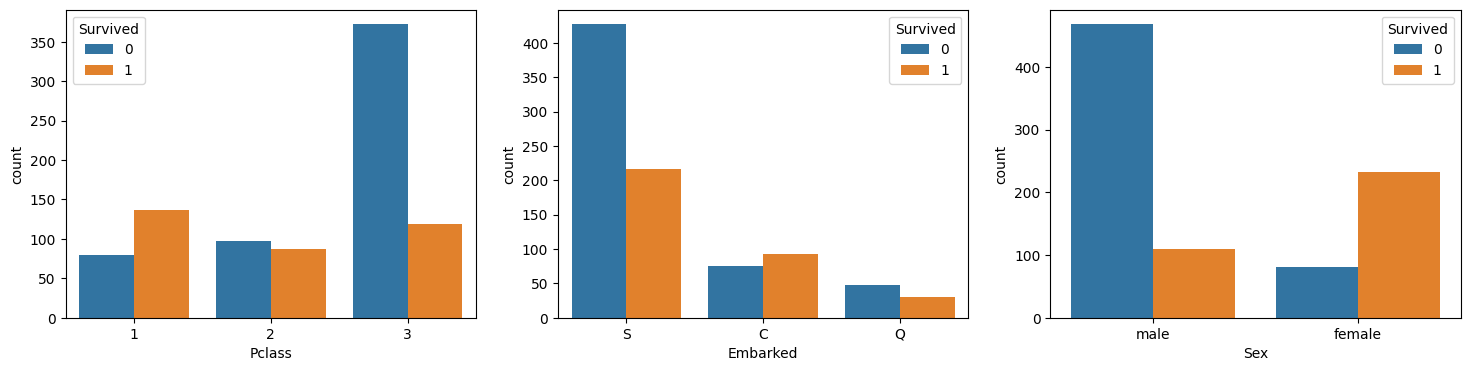

In [172]:
_,a=plt.subplots(1,3,figsize=(18,4))
cate_col=["Pclass","Embarked","Sex"]
for x in range(len(cate_col)):
  sb.countplot(data=train,x=cate_col[x],hue="Survived",ax=a[x])
plt.show()

In [161]:
import scipy.stats as sps
chi2_result=[]
cate_train=train[["Pclass","Embarked","Survived","Sex"]]
module=skimp.SimpleImputer(strategy="most_frequent")
test_dataset=pd.DataFrame(module.fit_transform(cate_train),columns=cate_train.columns)
for x in test_dataset.columns.difference(["Survived"]):
  ct=pd.crosstab(test_dataset["Survived"],test_dataset[x])
  statistic,pvalue,dof,expected=sps.chi2_contingency(ct)
  result="meaningful"
  if pvalue > 0.05:
    result="H_0"
  chi2_result.append({"Name":x,"statistic":statistic,"pvalue":pvalue,"result":result})

In [162]:
pd.DataFrame(chi2_result)

,Name,statistic,pvalue,result
0,Embarked,25.964453,2.300863e-06,meaningful
1,Pclass,102.888989,4.549252e-23,meaningful
2,Sex,260.717020,1.197357e-58,meaningful


array([[193.47474747, 355.52525253],
       [120.52525253, 221.47474747]])